# Note!

The mixed likelihood doesn't expose the hyperparameters of the likelihoods inside it - so these are fixed.

In [4]:
import GPy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from mix_integral import Mix_Integral
from mixed import Mixed
from scipy.stats import norm
#from squashed_probit import SquashedProbit
from GPy.likelihoods.link_functions import Probit as OldProbit
from shiftedprobit import ShiftedProbit

In [5]:
def squash(fs,variance):
    pb = GPy.likelihoods.link_functions.Probit()
    squashed = []
    grid = np.linspace(-100,100,15000)
    #print(pb.transf(10.0))
    for f in fs.flatten():
        val=np.sum(grid*norm.pdf(f,grid,np.sqrt(variance))*pb.transf(grid*1.0))/np.sum(norm.pdf(f,grid,np.sqrt(variance)))
        #val=np.sum(grid*norm.pdf(f,grid,np.sqrt(variance))*1)/np.sum(norm.pdf(f,grid,np.sqrt(variance)))
        squashed.append(val)
    return np.array(squashed).reshape(fs.shape)

def run_demo(n_non_negs=0,xlim=[0,26],ylim=[-40,50],lengthscale=None):
    X = 2.0*np.array([[1,0],[2,1],[3,2],[4,3],[10,9],[11,10],[12,11],[13,12]])
    X = np.c_[X,np.zeros([len(X),1])]
    Y = 10.0*np.array([[7,6,4,1,1,4,6,7]]).T
    Y+=np.random.randn(len(Y),1)*0.1

    fn_idx = np.zeros([len(X),1])
    non_negs_X = np.linspace(0,26,n_non_negs)[:,None]
    non_negs_X = np.c_[non_negs_X,np.zeros([len(non_negs_X),1]),np.ones([len(non_negs_X),1])]
    non_negs_Y = np.ones([len(non_negs_X),1])
    non_negs_fn_idx = np.ones_like(non_negs_Y)
    X = np.r_[X,non_negs_X]
    Y = np.r_[Y,non_negs_Y]
    fn_idx = (np.r_[fn_idx,non_negs_fn_idx]).astype(int)
    scaling = np.ones_like(fn_idx)/10
    Y_metadata = {'likelihood_fn_index':fn_idx}#,'scaling':scaling}
    


    kernel = Mix_Integral(3,variances=250.0,lengthscale=[5.0])
    likelihood_fns = [GPy.likelihoods.Gaussian(variance=1.0), GPy.likelihoods.Bernoulli(gp_link=ShiftedProbit(10,1))]

   # print(X)
   # print(Y)
   # print(Y_metadata['likelihood_fn_index'])
    
    m = GPy.core.GP( 
        X, Y,        
        kernel = kernel, 
        inference_method = GPy.inference.latent_function_inference.EP(),
        likelihood = Mixed(likelihood_fns=likelihood_fns),
        Y_metadata = Y_metadata,normalizer=False,
    )

    if lengthscale is not None:
        m.kern.lengthscale.fix(lengthscale)
    m.optimize(messages=True)
    print(m)

    testX = np.linspace(-5,30,500)[:,None]
    testX = np.c_[testX,np.zeros([len(testX),1]),np.ones([len(testX),1])]
    m.Y_metadata = None

    mu,var = m.predict_noiseless(testX)
    
    mu,K = m.predict_noiseless(testX,full_cov=True)
    sample = np.random.multivariate_normal(mu[:,0],K,size=100)
    
    
    

    if n_non_negs==0: #we assume we want a gaussian likelihood link
        plt.plot(testX[:,0],mu,'b-')
        plt.plot(testX[:,0],mu+np.sqrt(var)*1.96,'b--')
        plt.plot(testX[:,0],mu-np.sqrt(var)*1.96,'b--')
        #plt.plot(testX[:,0],mu+np.sqrt(var)*4,'b:',alpha=0.5)
        #plt.plot(testX[:,0],mu-np.sqrt(var)*4,'b:',alpha=0.5)
        plt.plot(testX[:,0],sample.T,'b-',alpha=0.05);
    else:
        variance = m.likelihood.likelihood_fns[0].variance[0]
        plt.plot(testX[:,0],squash(mu[:,0],variance),'b-')
        plt.plot(testX[:,0],squash((mu-np.sqrt(var)*1.96)[:,0],variance),'b--')
        plt.plot(testX[:,0],squash((mu+np.sqrt(var)*1.96)[:,0],variance),'b--')
        plt.plot(testX[:,0],squash(sample.T,variance),'b-',alpha=0.05);
        #plt.plot(testX[:,0],squash((mu-np.sqrt(var)*4)[:,0],variance),'b:',alpha=0.5)
        #plt.plot(testX[:,0],squash((mu+np.sqrt(var)*4)[:,0],variance),'b:',alpha=0.5)
    
    for x,y in zip(X,Y):
        if x[-1]==0:
            plt.plot([x[0],x[1],x[1],x[0],x[0]],[0,0,y/2,y/2,0],'k-')
        else:
            plt.plot([x[0],x[0]],[-1,-2],'r-')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.hlines(0,xlim[0],xlim[1],colors='k')
    return m,X,Y

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0005   4.141915e+01   3.505856e-04 
    00s18  0006   4.141821e+01   1.710037e-03 
    01s07  0040   4.046807e+01   2.500438e-10 
Runtime:     01s07
Optimization status: Converged


Name : gp
Objective : 40.46806621255746
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.                       |              value  |  constraints  |  priors
  mix_integral.variances    |  531.5741854385699  |      +ve      |        
  mix_integral.lengthscale  |  4.779965800449246  |      +ve      |        


Text(0.5, 1.0, 'Non-negative virtual points added')

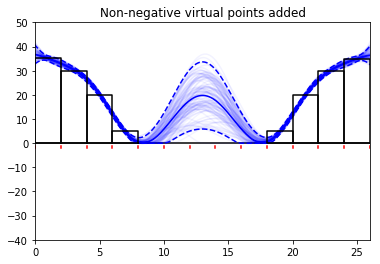

In [6]:
#m,X,Y=run_demo(0)
#plt.title('No non-negative virtual points')
#plt.savefig('gaussian_likelihood.pdf')
#plt.figure()
m,X,Y=run_demo(13+1)
plt.title('Non-negative virtual points added')
#plt.savefig('probit_virtual_points.pdf')
#plt.figure()
#m,X,Y=run_demo(13*4+1,lengthscale=2)
#plt.title('Non-negative virtual points, short lengthscale')
#plt.savefig('shortlengthscale.pdf')

In [6]:
debug

> /home/mike/anaconda3/lib/python3.6/site-packages/GPy/likelihoods/bernoulli.py(81)moments_match_ep()
     79         else:
     80             #TODO: do we want to revert to numerical quadrature here?
---> 81             raise ValueError("Exact moment matching not available for link {}".format(self.gp_link.__name__))
     82 
     83         # TODO: Output log_Z_hat instead of Z_hat (needs to be change in all others likelihoods)

ipdb> ll
     51     def moments_match_ep(self, Y_i, tau_i, v_i, Y_metadata_i=None):
     52         """
     53         Moments match of the marginal approximation in EP algorithm
     54 
     55         :param i: number of observation (int)
     56         :param tau_i: precision of the cavity distribution (float)
     57         :param v_i: mean/variance of the cavity distribution (float)
     58         """
     59         if Y_i == 1:
     60             sign = 1.
     61         elif Y_i == 0 or Y_i == -1:
     62             sign = -1
     63         

In [13]:
debug

> /home/mike/anaconda3/lib/python3.6/site-packages/GPy/inference/latent_function_inference/expectation_propagation.py(309)_local_updates()
    307                     Y_metadata_i = {}
    308                     for key in Y_metadata.keys():
--> 309                         Y_metadata_i[key] = Y_metadata[key][i, :]
    310                 else:
    311                     Y_metadata_i = None

ipdb> Y_metadata_i
{'likelihood_fn_index': array([0])}
ipdb> q


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0001   4.422759e+01   9.453480e+00 
    02s36  0016   4.155409e+01   5.460595e-02 
    04s48  0028   4.139148e+01   2.693511e-09 
Runtime:     04s48
Optimization status: Converged


Name : gp
Objective : 41.39147932416017
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.                       |              value  |  constraints  |  priors
  mix_integral.variances    |  512.7248627622625  |      +ve      |        
  mix_integral.lengthscale  |  4.409154149163536  |      +ve      |        
1.0
1.0
1.0
1.0


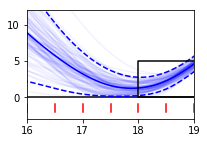

In [15]:
plt.figure(figsize=[3,2])
plt.savefig('probit_virtual_points_inset.pdf')
m=run_demo(13*4+1,xlim=[16,19],ylim=[-3,12])